複数モデルの平均値を取るブレンディングを実行
DT、LightGBM、XGBoostの三つのモデルを採用。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

import optuna.integration.lightgbm as lgb

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [4]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [5]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [6]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [7]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [20]:
pd.reset_option('display.max_rows')

モデル作成（3モデル）

In [21]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, y, test_size=0.3)

DTを使ったモデルを作る

In [23]:
clf_DT = DT()

In [24]:
parameters_DT = {"max_depth":list(range(2,16)), "min_samples_leaf":[50,60,70,80,90,100,110,120,130,140,150]}

In [25]:
model_DT = GridSearchCV(clf_DT, parameters_DT, cv=5, scoring="roc_auc",n_jobs=-1,return_train_score=True)
model_DT.fit(trainX,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15],
                         'min_samples_leaf': [50, 60, 70, 80, 90, 100, 110, 120,
                                              130, 140, 150]},
             return_train_score=True, scoring='roc_auc')

In [26]:
model_DT.best_params_

{'max_depth': 10, 'min_samples_leaf': 70}

In [27]:
trainXpred_DT = model_DT.predict_proba(trainX)
trainXpred_DT = trainXpred_DT[:,1]
trainXl_DT = len(trainXpred_DT)
trainXpred_DT = trainXpred_DT.astype(object)

In [28]:
ansRateList_DT = pd.DataFrame()
for j in range(25):
    c = trainXpred_DT.copy()
    n = (38+j)/100
    for i in range(trainXl_DT):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase_DT = np.equal(c,y)
    ansRate_DT = collections.Counter(ansRateBase_DT)[True]/len(ansRateBase_DT)
    ansRateData_DT = pd.DataFrame([[n,ansRate_DT]])
    ansRateList_DT = pd.concat([ansRateList_DT,ansRateData_DT],ignore_index=True)
ansRateList_DT

,0,1
0,0.38,0.849079
1,0.39,0.849079
2,0.40,0.849939
3,0.41,0.850860
4,0.42,0.851597
5,0.43,0.852518
6,0.44,0.853194
7,0.45,0.854238
8,0.46,0.854238
9,0.47,0.854238


([<matplotlib.axis.XTick at 0x2040fc3a790>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

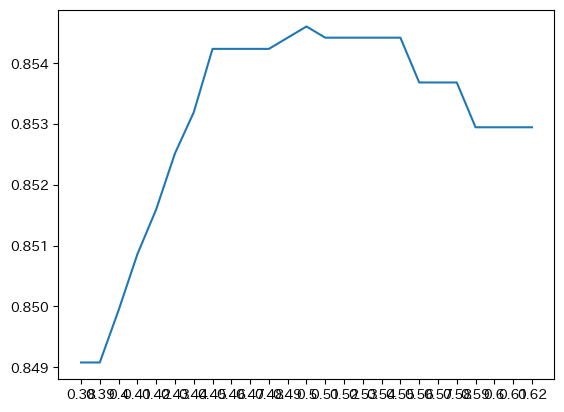

In [29]:
plt.plot(ansRateList_DT[1])
plt.xticks(range(25),ansRateList_DT[0])

LightGBMを使ったモデルを作る

In [30]:
dtrain = lgb.Dataset(X_train, y_train)
deval = lgb.Dataset(X_test, y_test, reference=dtrain)

best_params, history = {}, []

callbacks = [
    lgb.log_evaluation(10),
    lgb.early_stopping(20),
]

params = {'objective':'regression',
        'metric': 'rmse',
        'random_state': 42,
        'boosting_type': 'gbdt',
         }

model_LGB = lgb.train(params, dtrain, 
                    valid_sets=[dtrain, deval],
                    num_boost_round=100_000,
                    callbacks=callbacks,
                    )

[I 2023-02-21 13:49:03,009] A new study created in memory with name: no-name-7089370d-9f15-4b62-b40a-62dbb3d63b41
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.324947	valid_1's rmse: 0.333302
[20]	valid_0's rmse: 0.299931	valid_1's rmse: 0.314211
[30]	valid_0's rmse: 0.290294	valid_1's rmse: 0.30976
[40]	valid_0's rmse: 0.284002	valid_1's rmse: 0.307031


feature_fraction, val_score: 0.306638:  14%|#4        | 1/7 [00:00<00:03,  1.50it/s]

[50]	valid_0's rmse: 0.279761	valid_1's rmse: 0.306791
[60]	valid_0's rmse: 0.276675	valid_1's rmse: 0.306909
[70]	valid_0's rmse: 0.273891	valid_1's rmse: 0.307129
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.277834	valid_1's rmse: 0.306638
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.334589	valid_1's rmse: 0.341401


feature_fraction, val_score: 0.306638:  29%|##8       | 2/7 [00:00<00:02,  2.22it/s]

[20]	valid_0's rmse: 0.308718	valid_1's rmse: 0.320631
[30]	valid_0's rmse: 0.296838	valid_1's rmse: 0.312418
[40]	valid_0's rmse: 0.291602	valid_1's rmse: 0.310702
[50]	valid_0's rmse: 0.286898	valid_1's rmse: 0.308317
[60]	valid_0's rmse: 0.283494	valid_1's rmse: 0.306954
[70]	valid_0's rmse: 0.281058	valid_1's rmse: 0.306071
[80]	valid_0's rmse: 0.278964	valid_1's rmse: 0.305495
[90]	valid_0's rmse: 0.277204	valid_1's rmse: 0.305578
Early stopping, best iteration is:
[76]	valid_0's rmse: 0.272405	valid_1's rmse: 0.307329
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.328841	valid_1's rmse: 0.336728
[20]	valid_0's rmse: 0.302916	valid_1's rmse: 0.316827
[30]	valid_0's r

feature_fraction, val_score: 0.305441:  43%|####2     | 3/7 [00:01<00:01,  2.46it/s]

[110]	valid_0's rmse: 0.268712	valid_1's rmse: 0.305518
Early stopping, best iteration is:
[95]	valid_0's rmse: 0.276243	valid_1's rmse: 0.305441
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330495	valid_1's rmse: 0.337356
[20]	valid_0's rmse: 0.305084	valid_1's rmse: 0.31727
[30]	valid_0's rmse: 0.293578	valid_1's rmse: 0.310268
[40]	valid_0's rmse: 0.288573	valid_1's rmse: 0.309203


feature_fraction, val_score: 0.305053:  57%|#####7    | 4/7 [00:01<00:01,  2.57it/s]

[50]	valid_0's rmse: 0.284272	valid_1's rmse: 0.307234
[60]	valid_0's rmse: 0.280971	valid_1's rmse: 0.306302
[70]	valid_0's rmse: 0.278368	valid_1's rmse: 0.305728
[80]	valid_0's rmse: 0.276108	valid_1's rmse: 0.305271
[90]	valid_0's rmse: 0.274228	valid_1's rmse: 0.305112
[100]	valid_0's rmse: 0.272439	valid_1's rmse: 0.3052
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.324433	valid_1's rmse: 0.333254
[20]	valid_0's rmse: 0.299863	valid_1's rmse: 0.31451
[30]	valid_0's rmse: 0.29022	valid_1's rmse: 0.310295
[40]	valid

feature_fraction, val_score: 0.305053:  71%|#######1  | 5/7 [00:02<00:00,  2.74it/s]

[80]	valid_0's rmse: 0.271235	valid_1's rmse: 0.308335
[90]	valid_0's rmse: 0.268646	valid_1's rmse: 0.308368
[100]	valid_0's rmse: 0.266438	valid_1's rmse: 0.308289
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91



feature_fraction, val_score: 0.305053:  71%|#######1  | 5/7 [00:02<00:00,  2.74it/s]

[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.327247	valid_1's rmse: 0.335281
[20]	valid_0's rmse: 0.30109	valid_1's rmse: 0.314696
[30]	valid_0's rmse: 0.290985	valid_1's rmse: 0.309363
[40]	valid_0's rmse: 0.285468	valid_1's rmse: 0.307964
[50]	valid_0's rmse: 0.280929	valid_1's rmse: 0.30635
[60]	valid_0's rmse: 0.277633	valid_1's rmse: 0.306079
[70]	valid_0's rmse: 0.275099	valid_1's rmse: 0.305967
[80]	valid_0's rmse: 0.272584	valid_1's rmse: 0.30645
[90]	valid_0's rmse: 0.270443	valid_1's rmse: 0.306569
[100]	valid_0's rmse: 0.268042	valid_1's rmse: 0.306773
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


feature_fraction, val_score: 0.305053:  86%|########5 | 6/7 [00:02<00:00,  2.74it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.323997	valid_1's rmse: 0.332826
[20]	valid_0's rmse: 0.300024	valid_1's rmse: 0.315283
[30]	valid_0's rmse: 0.289555	valid_1's rmse: 0.308748
[40]	valid_0's rmse: 0.283579	valid_1's rmse: 0.307664
[50]	valid_0's rmse: 0.279409	valid_1's rmse: 0.307033
[60]	valid_0's rmse: 0.276392	valid_1's rmse: 0.306912
[70]	valid_0's rmse: 0.273856	valid_1's rmse: 0.307195
[80]	valid_0's rmse: 0.271487	valid_1's rmse: 0.307149


feature_fraction, val_score: 0.305053: 100%|##########| 7/7 [00:02<00:00,  2.60it/s]


[90]	valid_0's rmse: 0.269343	valid_1's rmse: 0.306894
[100]	valid_0's rmse: 0.267097	valid_1's rmse: 0.306969
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


num_leaves, val_score: 0.305053:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.328711	valid_1's rmse: 0.336677
[20]	valid_0's rmse: 0.302407	valid_1's rmse: 0.316716
[30]	valid_0's rmse: 0.29015	valid_1's rmse: 0.30998
[40]	valid_0's rmse: 0.284528	valid_1's rmse: 0.309233
[50]	valid_0's rmse: 0.279488	valid_1's rmse: 0.307229
[60]	valid_0's rmse: 0.275592	valid_1's rmse: 0.306288
[70]	valid_0's rmse: 0.273007	valid_1's rmse: 0.305679
[80]	valid_0's rmse: 0.270673	valid_1's rmse: 0.305606
[90]	valid_0's rmse: 0.268627	valid_1's rmse: 0.305645
[100]	valid_0's rmse: 0.266416	valid_1's rmse: 0.30586
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


num_leaves, val_score: 0.305053:   5%|5         | 1/20 [00:00<00:07,  2.63it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.318828	valid_1's rmse: 0.335839
[20]	valid_0's rmse: 0.286952	valid_1's rmse: 0.316555
[30]	valid_0's rmse: 0.269141	valid_1's rmse: 0.310687
[40]	valid_0's rmse: 0.259194	valid_1's rmse: 0.3108
[50]	valid_0's rmse: 0.251227	valid_1's rmse: 0.309619
[60]	valid_0's rmse: 0.243942	valid_1's rmse: 0.30993
[70]	valid_0's rmse: 0.238702	valid_1's rmse: 0.309885
[80]	valid_0's rmse: 0.234017	valid_1's rmse: 0.31052


num_leaves, val_score: 0.305053:  10%|#         | 2/20 [00:01<00:09,  1.87it/s]

[90]	valid_0's rmse: 0.229974	valid_1's rmse: 0.310512
[100]	valid_0's rmse: 0.225738	valid_1's rmse: 0.310804
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.31522	valid_1's rmse: 0.335792
[20]	valid_0's rmse: 0.281	valid_1's rmse: 0.317232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's rmse: 0.260362	valid_1's rmse: 0.312773
[Ligh

num_leaves, val_score: 0.305053:  15%|#5        | 3/20 [00:01<00:11,  1.50it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.315561	valid_1's rmse: 0.33595
[20]	valid_0's rmse: 0.281748	valid_1's rmse: 0.31729
[30]	valid_0's rmse: 0.261541	valid_1's rmse: 0.312275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's rmse: 0.249864	valid_1's rmse: 0.312905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 0.240635	valid_1's rmse: 0.311971
[60]	valid_0's rmse

num_leaves, val_score: 0.305053:  20%|##        | 4/20 [00:02<00:11,  1.33it/s]

[100]	valid_0's rmse: 0.209331	valid_1's rmse: 0.313931
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.318666	valid_1's rmse: 0.335858
[20]	valid_0's rmse: 0.286742	valid_1's rmse: 0.316579
[30]	valid_0's rmse: 0.268809	valid_1's rmse: 0.311298
[40]	valid_0's rmse: 0.258517	valid_1's rmse: 0.311422
[50]	valid_0's rmse: 0.250511	valid_1's rmse: 0.310567
[60]	valid_0's rmse: 0.243227	valid_1's rmse: 0.31057
[70]	valid_0's rmse: 0.237939	valid_1's rmse: 0.310533
[80]	valid_0's rmse: 0.23332	valid_1's rmse: 0.310817
[90]	val

num_leaves, val_score: 0.305053:  25%|##5       | 5/20 [00:03<00:10,  1.40it/s]

[100]	valid_0's rmse: 0.224726	valid_1's rmse: 0.310733
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.316152	valid_1's rmse: 0.335776
[20]	valid_0's rmse: 0.282754	valid_1's rmse: 0.316911
[30]	valid_0's rmse: 0.262358	valid_1's rmse: 0.311943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's rmse: 0.250841	valid_1's rmse: 0.312493
[

num_leaves, val_score: 0.305053:  30%|###       | 6/20 [00:04<00:10,  1.34it/s][I 2023-02-21 13:49:09,914] Trial 12 finished with value: 0.3050529490368523 and parameters: {'num_leaves': 159}. Best is trial 7 with value: 0.3050529490368523.


[90]	valid_0's rmse: 0.216901	valid_1's rmse: 0.312161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 0.21233	valid_1's rmse: 0.312431
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053



num_leaves, val_score: 0.305053:  30%|###       | 6/20 [00:04<00:10,  1.34it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330057	valid_1's rmse: 0.337192
[20]	valid_0's rmse: 0.304337	valid_1's rmse: 0.316955
[30]	valid_0's rmse: 0.292738	valid_1's rmse: 0.309823
[40]	valid_0's rmse: 0.287652	valid_1's rmse: 0.308917
[50]	valid_0's rmse: 0.283015	valid_1's rmse: 0.306926
[60]	valid_0's rmse: 0.279461	valid_1's rmse: 0.306414
[70]	valid_0's rmse: 0.276974	valid_1's rmse: 0.305912


num_leaves, val_score: 0.305053:  35%|###5      | 7/20 [00:04<00:07,  1.63it/s]

[80]	valid_0's rmse: 0.274842	valid_1's rmse: 0.305972
[90]	valid_0's rmse: 0.272849	valid_1's rmse: 0.305823
[100]	valid_0's rmse: 0.270916	valid_1's rmse: 0.305839
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.313235	valid_1's rmse: 0.335997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 0.277585	valid_1's rmse: 0.317687
[

num_leaves, val_score: 0.305053:  40%|####      | 8/20 [00:05<00:09,  1.28it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.31652	valid_1's rmse: 0.336077
[20]	valid_0's rmse: 0.283312	valid_1's rmse: 0.317082
[30]	valid_0's rmse: 0.263848	valid_1's rmse: 0.312601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's rmse: 0.252417	valid_1's rmse: 0.312679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 0.243553	valid_1's rmse: 0.311758
[60]	valid_0's rmse: 0.235272	valid_1's rmse: 0.311557
[70]	valid_0's rmse: 0.229118	valid_1'

num_leaves, val_score: 0.305053:  45%|####5     | 9/20 [00:06<00:08,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.313302	valid_1's rmse: 0.335853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 0.277647	valid_1's rmse: 0.317461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's rmse: 0.255236	valid_1's rmse: 0.312844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

num_leaves, val_score: 0.305053:  50%|#####     | 10/20 [00:07<00:09,  1.06it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91


num_leaves, val_score: 0.305053:  55%|#####5    | 11/20 [00:07<00:06,  1.38it/s]

[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.348748	valid_1's rmse: 0.351453
[20]	valid_0's rmse: 0.325573	valid_1's rmse: 0.330173
[30]	valid_0's rmse: 0.315035	valid_1's rmse: 0.321418
[40]	valid_0's rmse: 0.31073	valid_1's rmse: 0.318256
[50]	valid_0's rmse: 0.307591	valid_1's rmse: 0.31551
[60]	valid_0's rmse: 0.305163	valid_1's rmse: 0.313434
[70]	valid_0's rmse: 0.303494	valid_1's rmse: 0.312243
[80]	valid_0's rmse: 0.302271	valid_1's rmse: 0.311604
[90]	valid_0's rmse: 0.301251	valid_1's rmse: 0.311287
[100]	valid_0's rmse: 0.300313	valid_1's rmse: 0.311032
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the

num_leaves, val_score: 0.305053:  60%|######    | 12/20 [00:08<00:05,  1.39it/s]

[90]	valid_0's rmse: 0.24259	valid_1's rmse: 0.30901
[100]	valid_0's rmse: 0.23902	valid_1's rmse: 0.309411
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.323391	valid_1's rmse: 0.336041
[20]	valid_0's rmse: 0.294237	valid_1's rmse: 0.316697
[30]	valid_0's rmse: 0.27946	valid_1's rmse: 0.310418
[40]	valid_0's rmse: 0.271479	valid_1's rmse: 0.310431
[50]	valid_0's rmse: 0.264861	valid_1's rmse: 0.308888
[60]	valid_0's rmse: 0.259498	valid_1's rmse: 0.30836


num_leaves, val_score: 0.305053:  65%|######5   | 13/20 [00:09<00:04,  1.53it/s]

[70]	valid_0's rmse: 0.255238	valid_1's rmse: 0.307895
[80]	valid_0's rmse: 0.251935	valid_1's rmse: 0.308017
[90]	valid_0's rmse: 0.248753	valid_1's rmse: 0.308228
[100]	valid_0's rmse: 0.245934	valid_1's rmse: 0.30841
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.32523	valid_1's rmse: 0.335962
[20]	valid_0's rmse: 0.297277	valid_1's rmse: 0.316499
[30]	valid_0's rmse: 0.283269	valid_1's rmse: 0.310136
[40]	valid_0's rmse: 0.27616	valid_1's rmse: 0.309742
[50]	valid_0's rmse: 0.270149	valid_1's rmse: 0.308072
[60]	vali

num_leaves, val_score: 0.305053:  70%|#######   | 14/20 [00:09<00:03,  1.60it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.319585	valid_1's rmse: 0.33629
[20]	valid_0's rmse: 0.288077	valid_1's rmse: 0.316862
[30]	valid_0's rmse: 0.270708	valid_1's rmse: 0.311346
[40]	valid_0's rmse: 0.261194	valid_1's rmse: 0.311342
[50]	valid_0's rmse: 0.253295	valid_1's rmse: 0.309961
[60]	valid_0's rmse: 0.246175	valid_1's rmse: 0.309959
[70]	valid_0's rmse: 0.240901	valid_1's rmse: 0.310077
[80]	valid_0's rmse: 0.236724	valid_1's rmse: 0.310382
[90]	valid_0's rmse: 0.232523	valid_1's rmse: 0.310731
[100]	va

num_leaves, val_score: 0.305053:  80%|########  | 16/20 [00:10<00:02,  1.96it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.360157	valid_1's rmse: 0.361273
[20]	valid_0's rmse: 0.337721	valid_1's rmse: 0.340281
[30]	valid_0's rmse: 0.326778	valid_1's rmse: 0.330724
[40]	valid_0's rmse: 0.32228	valid_1's rmse: 0.327382
[50]	valid_0's rmse: 0.31903	valid_1's rmse: 0.324676
[60]	valid_0's rmse: 0.31684	valid_1's rmse: 0.322863
[70]	valid_0's rmse: 0.31518	valid_1's rmse: 0.321445
[80]	valid_0's rmse: 0.313993	valid_1's rmse: 0.320543
[90]	valid_0's rmse: 0.312978	valid_1's rmse: 0.319948
[100]	valid_0's rmse: 0.312185	valid_1's rmse: 0.319325
Early stopping, best iteration is:
[89]	valid

num_leaves, val_score: 0.305053:  85%|########5 | 17/20 [00:11<00:02,  1.41it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330057	valid_1's rmse: 0.337192
[20]	valid_0's rmse: 0.304337	valid_1's rmse: 0.316955
[30]	valid_0's rmse: 0.292738	valid_1's rmse: 0.309823
[40]	valid_0's rmse: 0.287652	valid_1's rmse: 0.308917
[50]	valid_0's rmse: 0.283015	valid_1's rmse: 0.306926
[60]	valid_0's rmse: 0.279461	valid_1's rmse: 0.306414
[70]	valid_0's rmse: 0.276974	valid_1's rmse: 0.305912
[80]	valid_0's rmse: 0.274842	valid_1's rmse: 0.305972
[90]	valid_0's rmse: 0.272849	valid_1's rmse: 0.305823
[100]	v

num_leaves, val_score: 0.305053:  90%|######### | 18/20 [00:12<00:01,  1.66it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.314301	valid_1's rmse: 0.335727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 0.279532	valid_1's rmse: 0.317337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's rmse: 0.25816	valid_1's rmse: 0.312822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's rmse: 0.245017	valid_1's rmse: 0.31369

num_leaves, val_score: 0.305053:  95%|#########5| 19/20 [00:13<00:00,  1.43it/s]

[100]	valid_0's rmse: 0.201471	valid_1's rmse: 0.314971
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.321669	valid_1's rmse: 0.33579
[20]	valid_0's rmse: 0.291591	valid_1's rmse: 0.316302
[30]	valid_0's rmse: 0.275916	valid_1's rmse: 0.310587
[40]	valid_0's rmse: 0.26743	valid_1's rmse: 0.310279
[50]	valid_0's rmse: 0.260419	valid_1's rmse: 0.309154



num_leaves, val_score: 0.305053:  95%|#########5| 19/20 [00:13<00:00,  1.43it/s]

[60]	valid_0's rmse: 0.254661	valid_1's rmse: 0.309047
[70]	valid_0's rmse: 0.250104	valid_1's rmse: 0.30865
[80]	valid_0's rmse: 0.246323	valid_1's rmse: 0.308646
[90]	valid_0's rmse: 0.24259	valid_1's rmse: 0.30901
[100]	valid_0's rmse: 0.23902	valid_1's rmse: 0.309411
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


bagging, val_score: 0.305053:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.333645	valid_1's rmse: 0.340444
[20]	valid_0's rmse: 0.308532	valid_1's rmse: 0.32062
[30]	valid_0's rmse: 0.298115	valid_1's rmse: 0.314435
[40]	valid_0's rmse: 0.293454	valid_1's rmse: 0.312914
[50]	valid_0's rmse: 0.289556	valid_1's rmse: 0.311852
[60]	valid_0's rmse: 0.286146	valid_1's rmse: 0.31142


bagging, val_score: 0.305053:  10%|#         | 1/10 [00:00<00:03,  2.65it/s]

[70]	valid_0's rmse: 0.28399	valid_1's rmse: 0.31059
[80]	valid_0's rmse: 0.28191	valid_1's rmse: 0.310892
[90]	valid_0's rmse: 0.280112	valid_1's rmse: 0.311201
[100]	valid_0's rmse: 0.278307	valid_1's rmse: 0.312105
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.331659	valid_1's rmse: 0.339163
[20]	valid_0's rmse: 0.306289	valid_1's rmse: 0.319127
[30]	valid_0's rmse: 0.294975	valid_1's rmse: 0.312144
[40]	valid_0's rmse: 0.289865	valid_1's rmse: 0.310744
[50]	valid_0's rmse: 0.285428	valid_1's rmse: 0.308606
[60]	vali

bagging, val_score: 0.305053:  20%|##        | 2/10 [00:00<00:02,  2.90it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.332255	valid_1's rmse: 0.339437
[20]	valid_0's rmse: 0.306983	valid_1's rmse: 0.319202
[30]	valid_0's rmse: 0.295679	valid_1's rmse: 0.312406
[40]	valid_0's rmse: 0.290552	valid_1's rmse: 0.311753
[50]	valid_0's rmse: 0.286338	valid_1's rmse: 0.309972
[60]	valid_0's rmse: 0.282912	valid_1's rmse: 0.309255


bagging, val_score: 0.305053:  30%|###       | 3/10 [00:01<00:02,  2.73it/s]

[70]	valid_0's rmse: 0.280233	valid_1's rmse: 0.309279
[80]	valid_0's rmse: 0.277877	valid_1's rmse: 0.309264
[90]	valid_0's rmse: 0.275774	valid_1's rmse: 0.309489
[100]	valid_0's rmse: 0.273833	valid_1's rmse: 0.309651
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261



bagging, val_score: 0.305053:  30%|###       | 3/10 [00:01<00:02,  2.73it/s]

[10]	valid_0's rmse: 0.333288	valid_1's rmse: 0.339803
[20]	valid_0's rmse: 0.308378	valid_1's rmse: 0.320025
[30]	valid_0's rmse: 0.297492	valid_1's rmse: 0.314013
[40]	valid_0's rmse: 0.292816	valid_1's rmse: 0.313497
[50]	valid_0's rmse: 0.288418	valid_1's rmse: 0.311669
[60]	valid_0's rmse: 0.285154	valid_1's rmse: 0.311127
[70]	valid_0's rmse: 0.282755	valid_1's rmse: 0.31076
[80]	valid_0's rmse: 0.28033	valid_1's rmse: 0.310385
[90]	valid_0's rmse: 0.278228	valid_1's rmse: 0.310493
[100]	valid_0's rmse: 0.276438	valid_1's rmse: 0.310207
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


bagging, val_score: 0.305053:  40%|####      | 4/10 [00:01<00:02,  2.87it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.332092	valid_1's rmse: 0.338875
[20]	valid_0's rmse: 0.306965	valid_1's rmse: 0.318789
[30]	valid_0's rmse: 0.296191	valid_1's rmse: 0.313034
[40]	valid_0's rmse: 0.291079	valid_1's rmse: 0.312122
[50]	valid_0's rmse: 0.28673	valid_1's rmse: 0.310022
[60]	valid_0's rmse: 0.28349	valid_1's rmse: 0.309651


bagging, val_score: 0.305053:  50%|#####     | 5/10 [00:01<00:01,  2.88it/s]

[70]	valid_0's rmse: 0.280914	valid_1's rmse: 0.309374
[80]	valid_0's rmse: 0.278688	valid_1's rmse: 0.309596
[90]	valid_0's rmse: 0.276631	valid_1's rmse: 0.309216
[100]	valid_0's rmse: 0.274556	valid_1's rmse: 0.30901
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330889	valid_1's rmse: 0.337674



bagging, val_score: 0.305053:  50%|#####     | 5/10 [00:02<00:01,  2.88it/s]

[20]	valid_0's rmse: 0.305915	valid_1's rmse: 0.318013
[30]	valid_0's rmse: 0.294666	valid_1's rmse: 0.311428
[40]	valid_0's rmse: 0.289448	valid_1's rmse: 0.310154
[50]	valid_0's rmse: 0.284821	valid_1's rmse: 0.30772
[60]	valid_0's rmse: 0.281212	valid_1's rmse: 0.306781
[70]	valid_0's rmse: 0.278427	valid_1's rmse: 0.306322
[80]	valid_0's rmse: 0.276212	valid_1's rmse: 0.306063
[90]	valid_0's rmse: 0.274127	valid_1's rmse: 0.305902
[100]	valid_0's rmse: 0.272249	valid_1's rmse: 0.305867
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


bagging, val_score: 0.305053:  60%|######    | 6/10 [00:02<00:01,  2.91it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.333644	valid_1's rmse: 0.340745
[20]	valid_0's rmse: 0.309199	valid_1's rmse: 0.321602
[30]	valid_0's rmse: 0.29867	valid_1's rmse: 0.316329
[40]	valid_0's rmse: 0.294113	valid_1's rmse: 0.315245
[50]	valid_0's rmse: 0.289808	valid_1's rmse: 0.313317
[60]	valid_0's rmse: 0.28626	valid_1's rmse: 0.312493


bagging, val_score: 0.305053:  70%|#######   | 7/10 [00:02<00:01,  2.83it/s]

[70]	valid_0's rmse: 0.283709	valid_1's rmse: 0.312794
[80]	valid_0's rmse: 0.281486	valid_1's rmse: 0.312822
[90]	valid_0's rmse: 0.279387	valid_1's rmse: 0.31283
[100]	valid_0's rmse: 0.277553	valid_1's rmse: 0.313064
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330486	valid_1's rmse: 0.337356
[20]	valid_0's rmse: 0.305213	valid_1's rmse: 0.317389
[30]	valid_0's rmse: 0.293827	valid_1's rmse: 0.310513
[40]	valid_0's rmse: 0.288703	valid_1's rmse: 0.308988
[50]	valid_0's rmse: 0.284289	valid_1's rmse: 0.307206
[60]	valid_0's rmse: 0.281034	valid_1's rmse: 0.306507
[70]	valid_0's r

bagging, val_score: 0.305053:  80%|########  | 8/10 [00:02<00:00,  2.68it/s]

[100]	valid_0's rmse: 0.272495	valid_1's rmse: 0.30621
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330727	valid_1's rmse: 0.337414
[20]	valid_0's rmse: 0.305259	valid_1's rmse: 0.317119
[30]	valid_0's rmse: 0.294067	valid_1's rmse: 0.31003


bagging, val_score: 0.305053:  90%|######### | 9/10 [00:03<00:00,  2.76it/s]

[40]	valid_0's rmse: 0.289011	valid_1's rmse: 0.308696
[50]	valid_0's rmse: 0.284588	valid_1's rmse: 0.30679
[60]	valid_0's rmse: 0.281114	valid_1's rmse: 0.306099
[70]	valid_0's rmse: 0.278471	valid_1's rmse: 0.305726
[80]	valid_0's rmse: 0.276272	valid_1's rmse: 0.305715
[90]	valid_0's rmse: 0.273974	valid_1's rmse: 0.305647
[100]	valid_0's rmse: 0.272085	valid_1's rmse: 0.305613
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.33199	valid_1's rmse: 0.339377
[20]	valid_0's rmse: 0.307086	valid_1's rmse: 0.319392
[30]	val

bagging, val_score: 0.305053: 100%|##########| 10/10 [00:03<00:00,  2.81it/s]


[100]	valid_0's rmse: 0.274312	valid_1's rmse: 0.308564
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


feature_fraction_stage2, val_score: 0.305053:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.332443	valid_1's rmse: 0.339265
[20]	valid_0's rmse: 0.307259	valid_1's rmse: 0.318869
[30]	valid_0's rmse: 0.295569	valid_1's rmse: 0.311324
[40]	valid_0's rmse: 0.290407	valid_1's rmse: 0.309857
[50]	valid_0's rmse: 0.286204	valid_1's rmse: 0.308089
[60]	valid_0's rmse: 0.28264	valid_1's rmse: 0.307143
[70]	valid_0's rmse: 0.280008	valid_1's rmse: 0.306471
[80]	valid_0's rmse: 0.277954	valid_1's rmse: 0.305988


feature_fraction_stage2, val_score: 0.305053:  17%|#6        | 1/6 [00:00<00:01,  3.24it/s]

[90]	valid_0's rmse: 0.276033	valid_1's rmse: 0.305793
[100]	valid_0's rmse: 0.274289	valid_1's rmse: 0.305922
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.32915	valid_1's rmse: 0.336805
[20]	valid_0's rmse: 0.303685	valid_1's rmse: 0.316514
[30]	valid_0's rmse: 0.292766	valid_1's rmse: 0.309967
[40]	valid_0's rmse: 0.287818	valid_1's rmse: 0.309019
[50]	valid_0's rmse: 0.283083	valid_1's rmse: 0.306656
[60]	valid_0's rmse: 0.279721	valid_1's rmse: 0.306113
[70]	valid_0's rmse: 0.277153	valid_1's rmse: 0.305295
[80]	va

feature_fraction_stage2, val_score: 0.305053:  33%|###3      | 2/6 [00:00<00:01,  3.27it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.329925	valid_1's rmse: 0.337257
[20]	valid_0's rmse: 0.304967	valid_1's rmse: 0.317401
[30]	valid_0's rmse: 0.293461	valid_1's rmse: 0.310723
[40]	valid_0's rmse: 0.288213	valid_1's rmse: 0.309307
[50]	valid_0's rmse: 0.283614	valid_1's rmse: 0.307413
[60]	valid_0's rmse: 0.280196	valid_1's rmse: 0.306861
[70]	valid_0's rmse: 0.277542	valid_1's rmse: 0.306034
[80]	valid_0's rmse: 0.27546	valid_1's rmse: 0.305932
[90]	valid_0's rmse: 0.273312	valid_1's rmse: 0.305919
[100]	va

feature_fraction_stage2, val_score: 0.305053:  50%|#####     | 3/6 [00:00<00:00,  3.19it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.331672	valid_1's rmse: 0.33812
[20]	valid_0's rmse: 0.306729	valid_1's rmse: 0.318295
[30]	valid_0's rmse: 0.295756	valid_1's rmse: 0.31103
[40]	valid_0's rmse: 0.290686	valid_1's rmse: 0.309125
[50]	valid_0's rmse: 0.286396	valid_1's rmse: 0.30754
[60]	valid_0's rmse: 0.282896	valid_1's rmse: 0.306639
[70]	valid_0's rmse: 0.280301	valid_1's rmse: 0.305804
[80]	valid_0's rmse: 0.278093	valid_1's rmse: 0.305394
[90]	valid_0's rmse: 0.276066	valid_1's rmse: 0.305437


feature_fraction_stage2, val_score: 0.305053:  67%|######6   | 4/6 [00:01<00:00,  2.98it/s]

[100]	valid_0's rmse: 0.274134	valid_1's rmse: 0.30542
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


[I 2023-02-21 13:49:24,205] Trial 40 finished with value: 0.3050529490368523 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.3050529490368523.
feature_fraction_stage2, val_score: 0.305053:  67%|######6   | 4/6 [00:01<00:00,  2.98it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.331441	valid_1's rmse: 0.337887
[20]	valid_0's rmse: 0.305703	valid_1's rmse: 0.317377
[30]	valid_0's rmse: 0.294172	valid_1's rmse: 0.310158
[40]	valid_0's rmse: 0.289044	valid_1's rmse: 0.308986
[50]	valid_0's rmse: 0.284468	valid_1's rmse: 0.30717
[60]	valid_0's rmse: 0.281122	valid_1's rmse: 0.306385
[70]	valid_0's rmse: 0.278591	valid_1's rmse: 0.305837
[80]	valid_0's rmse: 0.276183	valid_1's rmse: 0.305913
[90]	valid_0's rmse: 0.274342	valid_1's rmse: 0.305775
[100]	valid_0's rmse: 0.272477	valid_1's rmse: 0.305896


feature_fraction_stage2, val_score: 0.305053:  83%|########3 | 5/6 [00:01<00:00,  3.07it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.329971	valid_1's rmse: 0.33689
[20]	valid_0's rmse: 0.304794	valid_1's rmse: 0.316874
[30]	valid_0's rmse: 0.293416	valid_1's rmse: 0.310223
[40]	valid_0's rmse: 0.288313	valid_1's rmse: 0.308863
[50]	valid_0's rmse: 0.283989	valid_1's rmse: 0.307334
[60]	valid_0's rmse: 0.280485	valid_1's rmse: 0.306836
[70]	valid_0's rmse: 0.277884	valid_1's rmse: 0.306222
[80]	valid_0's rmse: 0.275579	valid_1's rmse: 0.306118
[90]	valid_0's rmse: 0.273726	valid_1's rmse: 0.305939
[100]	va

regularization_factors, val_score: 0.305053:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330891	valid_1's rmse: 0.337147
[20]	valid_0's rmse: 0.305196	valid_1's rmse: 0.316861
[30]	valid_0's rmse: 0.293878	valid_1's rmse: 0.310104
[40]	valid_0's rmse: 0.288932	valid_1's rmse: 0.309161
[50]	valid_0's rmse: 0.284384	valid_1's rmse: 0.307153


regularization_factors, val_score: 0.305053:   5%|5         | 1/20 [00:00<00:07,  2.60it/s]

[60]	valid_0's rmse: 0.281179	valid_1's rmse: 0.306464
[70]	valid_0's rmse: 0.278527	valid_1's rmse: 0.305829
[80]	valid_0's rmse: 0.276371	valid_1's rmse: 0.305834
[90]	valid_0's rmse: 0.27453	valid_1's rmse: 0.30588
[100]	valid_0's rmse: 0.272783	valid_1's rmse: 0.305911
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330864	valid_1's rmse: 0.336994
[20]	valid_0's rmse: 0.305257	valid_1's rmse: 0.316653
[30]	valid_0's rmse: 0.293809	valid_1's rmse: 0.309845
[40]	valid_0's rmse: 0.288942	valid_1's rmse: 0.30905
[50]	vali

regularization_factors, val_score: 0.305053:  10%|#         | 2/20 [00:00<00:06,  2.77it/s]

[100]	valid_0's rmse: 0.272904	valid_1's rmse: 0.306136
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330535	valid_1's rmse: 0.337145
[20]	valid_0's rmse: 0.30495	valid_1's rmse: 0.31691


regularization_factors, val_score: 0.305053:  15%|#5        | 3/20 [00:01<00:06,  2.75it/s]

[30]	valid_0's rmse: 0.293612	valid_1's rmse: 0.309583
[40]	valid_0's rmse: 0.28858	valid_1's rmse: 0.308651
[50]	valid_0's rmse: 0.28435	valid_1's rmse: 0.306907
[60]	valid_0's rmse: 0.280934	valid_1's rmse: 0.305979
[70]	valid_0's rmse: 0.278367	valid_1's rmse: 0.305482
[80]	valid_0's rmse: 0.276215	valid_1's rmse: 0.305443
[90]	valid_0's rmse: 0.274214	valid_1's rmse: 0.305445
[100]	valid_0's rmse: 0.272163	valid_1's rmse: 0.305296
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.331208	valid_1's rmse: 0.33746
[20]	vali

regularization_factors, val_score: 0.305053:  20%|##        | 4/20 [00:01<00:05,  2.92it/s]

[90]	valid_0's rmse: 0.275661	valid_1's rmse: 0.306578
[100]	valid_0's rmse: 0.273949	valid_1's rmse: 0.306606
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330575	valid_1's rmse: 0.337288
[20]	valid_0's rmse: 0.305118	valid_1's rmse: 0.317198
[30]	valid_0's rmse: 0.293725	valid_1's rmse: 0.31027
[40]	valid_0's rmse: 0.288811	valid_1's rmse: 0.309224


regularization_factors, val_score: 0.305053:  25%|##5       | 5/20 [00:01<00:04,  3.05it/s]

[50]	valid_0's rmse: 0.284452	valid_1's rmse: 0.3076
[60]	valid_0's rmse: 0.281248	valid_1's rmse: 0.306855
[70]	valid_0's rmse: 0.278692	valid_1's rmse: 0.306316
[80]	valid_0's rmse: 0.276491	valid_1's rmse: 0.306122
[90]	valid_0's rmse: 0.274613	valid_1's rmse: 0.306291
[100]	valid_0's rmse: 0.272766	valid_1's rmse: 0.306231
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261


regularization_factors, val_score: 0.305053:  30%|###       | 6/20 [00:02<00:04,  3.14it/s]

[10]	valid_0's rmse: 0.331316	valid_1's rmse: 0.337734
[20]	valid_0's rmse: 0.306013	valid_1's rmse: 0.317653
[30]	valid_0's rmse: 0.294913	valid_1's rmse: 0.310963
[40]	valid_0's rmse: 0.290167	valid_1's rmse: 0.309743
[50]	valid_0's rmse: 0.285931	valid_1's rmse: 0.307779
[60]	valid_0's rmse: 0.282869	valid_1's rmse: 0.307084
[70]	valid_0's rmse: 0.280392	valid_1's rmse: 0.306478
[80]	valid_0's rmse: 0.278288	valid_1's rmse: 0.306299
[90]	valid_0's rmse: 0.276444	valid_1's rmse: 0.306157
[100]	valid_0's rmse: 0.27485	valid_1's rmse: 0.306161
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[Ligh

regularization_factors, val_score: 0.305053:  35%|###5      | 7/20 [00:02<00:04,  3.21it/s]

[100]	valid_0's rmse: 0.272439	valid_1's rmse: 0.3052
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330833	valid_1's rmse: 0.336998
[20]	valid_0's rmse: 0.305204	valid_1's rmse: 0.316696
[30]	valid_0's rmse: 0.293929	valid_1's rmse: 0.310176
[40]	valid_0's rmse: 0.289076	valid_1's rmse: 0.309273


regularization_factors, val_score: 0.305053:  40%|####      | 8/20 [00:02<00:03,  3.19it/s]

[50]	valid_0's rmse: 0.284554	valid_1's rmse: 0.307521
[60]	valid_0's rmse: 0.281119	valid_1's rmse: 0.307135
[70]	valid_0's rmse: 0.278576	valid_1's rmse: 0.306461
[80]	valid_0's rmse: 0.276145	valid_1's rmse: 0.306324
[90]	valid_0's rmse: 0.274335	valid_1's rmse: 0.306256
[100]	valid_0's rmse: 0.272509	valid_1's rmse: 0.306249
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91



regularization_factors, val_score: 0.305053:  40%|####      | 8/20 [00:02<00:03,  3.19it/s]

[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.33218	valid_1's rmse: 0.338625
[20]	valid_0's rmse: 0.307029	valid_1's rmse: 0.318771
[30]	valid_0's rmse: 0.29601	valid_1's rmse: 0.311753
[40]	valid_0's rmse: 0.291363	valid_1's rmse: 0.310537
[50]	valid_0's rmse: 0.287325	valid_1's rmse: 0.30864
[60]	valid_0's rmse: 0.284115	valid_1's rmse: 0.307801
[70]	valid_0's rmse: 0.281781	valid_1's rmse: 0.30691
[80]	valid_0's rmse: 0.279849	valid_1's rmse: 0.306603
[90]	valid_0's rmse: 0.278132	valid_1's rmse: 0.306584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 0.276568	valid_1's rmse: 0.306554
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


regularization_factors, val_score: 0.305053:  45%|####5     | 9/20 [00:02<00:03,  3.25it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330624	valid_1's rmse: 0.337361
[20]	valid_0's rmse: 0.305126	valid_1's rmse: 0.317456
[30]	valid_0's rmse: 0.293777	valid_1's rmse: 0.310447
[40]	valid_0's rmse: 0.288755	valid_1's rmse: 0.309164
[50]	valid_0's rmse: 0.284307	valid_1's rmse: 0.307394
[60]	valid_0's rmse: 0.28095	valid_1's rmse: 0.306377
[70]	valid_0's rmse: 0.278367	valid_1's rmse: 0.305966
[80]	valid_0's rmse: 0.276148	valid_1's rmse: 0.305891


regularization_factors, val_score: 0.305053:  50%|#####     | 10/20 [00:03<00:03,  3.20it/s]

[90]	valid_0's rmse: 0.274137	valid_1's rmse: 0.30575
[100]	valid_0's rmse: 0.27231	valid_1's rmse: 0.305683
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.332553	valid_1's rmse: 0.338795
[20]	valid_0's rmse: 0.306976	valid_1's rmse: 0.318399



regularization_factors, val_score: 0.305053:  50%|#####     | 10/20 [00:03<00:03,  3.20it/s]

[30]	valid_0's rmse: 0.295584	valid_1's rmse: 0.311503
[40]	valid_0's rmse: 0.290585	valid_1's rmse: 0.310265
[50]	valid_0's rmse: 0.286229	valid_1's rmse: 0.308253
[60]	valid_0's rmse: 0.282914	valid_1's rmse: 0.307228
[70]	valid_0's rmse: 0.280466	valid_1's rmse: 0.306663
[80]	valid_0's rmse: 0.278609	valid_1's rmse: 0.306158
[90]	valid_0's rmse: 0.276782	valid_1's rmse: 0.306272
[100]	valid_0's rmse: 0.274934	valid_1's rmse: 0.306232
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


regularization_factors, val_score: 0.305053:  55%|#####5    | 11/20 [00:03<00:02,  3.03it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330577	valid_1's rmse: 0.337312
[20]	valid_0's rmse: 0.305109	valid_1's rmse: 0.31722
[30]	valid_0's rmse: 0.293718	valid_1's rmse: 0.309884
[40]	valid_0's rmse: 0.288825	valid_1's rmse: 0.30903
[50]	valid_0's rmse: 0.284303	valid_1's rmse: 0.307187
[60]	valid_0's rmse: 0.281175	valid_1's rmse: 0.306212
[70]	valid_0's rmse: 0.278694	valid_1's rmse: 0.305586


regularization_factors, val_score: 0.305053:  60%|######    | 12/20 [00:03<00:02,  3.00it/s]

[80]	valid_0's rmse: 0.27653	valid_1's rmse: 0.305607
[90]	valid_0's rmse: 0.274542	valid_1's rmse: 0.305803
[100]	valid_0's rmse: 0.272642	valid_1's rmse: 0.305743
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330585	valid_1's rmse: 0.337318



regularization_factors, val_score: 0.305053:  60%|######    | 12/20 [00:04<00:02,  3.00it/s]

[20]	valid_0's rmse: 0.305125	valid_1's rmse: 0.317252
[30]	valid_0's rmse: 0.293739	valid_1's rmse: 0.310251
[40]	valid_0's rmse: 0.288784	valid_1's rmse: 0.308951
[50]	valid_0's rmse: 0.284393	valid_1's rmse: 0.307045
[60]	valid_0's rmse: 0.280983	valid_1's rmse: 0.306262
[70]	valid_0's rmse: 0.27831	valid_1's rmse: 0.305643
[80]	valid_0's rmse: 0.276157	valid_1's rmse: 0.305278
[90]	valid_0's rmse: 0.274202	valid_1's rmse: 0.305332
[100]	valid_0's rmse: 0.272671	valid_1's rmse: 0.305381
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


regularization_factors, val_score: 0.305053:  65%|######5   | 13/20 [00:04<00:02,  2.96it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 0.339298	valid_1's rmse: 0.343821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 0.315419	valid_1's rmse: 0.323606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's rmse: 0.305608	va

regularization_factors, val_score: 0.305053:  70%|#######   | 14/20 [00:04<00:02,  2.94it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's rmse: 0.293436	valid_1's rmse: 0.310256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 0.292494	valid_1's rmse: 0.310062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 0.29157	valid_1's rmse: 0.309868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.30

regularization_factors, val_score: 0.305053:  75%|#######5  | 15/20 [00:05<00:01,  2.88it/s]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330495	valid_1's rmse: 0.337357
[20]	valid_0's rmse: 0.305084	valid_1's rmse: 0.31727
[30]	valid_0's rmse: 0.293532	valid_1's rmse: 0.310424
[40]	valid_0's rmse: 0.288529	valid_1's rmse: 0.309297


regularization_factors, val_score: 0.305053:  80%|########  | 16/20 [00:05<00:01,  2.82it/s]

[50]	valid_0's rmse: 0.283998	valid_1's rmse: 0.307546
[60]	valid_0's rmse: 0.280568	valid_1's rmse: 0.306392
[70]	valid_0's rmse: 0.277901	valid_1's rmse: 0.305594
[80]	valid_0's rmse: 0.275743	valid_1's rmse: 0.305216
[90]	valid_0's rmse: 0.273689	valid_1's rmse: 0.30525
[100]	valid_0's rmse: 0.27193	valid_1's rmse: 0.305427
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330884	valid_1's rmse: 0.337104
[20]	valid_0's rmse: 0.30524	valid_1's rmse: 0.31678
[30]	valid_0's rmse: 0.293928	valid_1's rmse: 0.3099
[40]	valid_0's rmse: 0.289006	valid_1's rmse: 0.308797
[50]	valid_0's rmse: 

regularization_factors, val_score: 0.305053:  85%|########5 | 17/20 [00:05<00:01,  2.78it/s]

[100]	valid_0's rmse: 0.272474	valid_1's rmse: 0.305679
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330814	valid_1's rmse: 0.336955
[20]	valid_0's rmse: 0.30518	valid_1's rmse: 0.31665
[30]	valid_0's rmse: 0.293907	valid_1's rmse: 0.310112


regularization_factors, val_score: 0.305053:  90%|######### | 18/20 [00:06<00:00,  2.81it/s]

[40]	valid_0's rmse: 0.288963	valid_1's rmse: 0.309023
[50]	valid_0's rmse: 0.284525	valid_1's rmse: 0.307189
[60]	valid_0's rmse: 0.28127	valid_1's rmse: 0.306382
[70]	valid_0's rmse: 0.278736	valid_1's rmse: 0.305639
[80]	valid_0's rmse: 0.276665	valid_1's rmse: 0.305633
[90]	valid_0's rmse: 0.274689	valid_1's rmse: 0.305782
[100]	valid_0's rmse: 0.272919	valid_1's rmse: 0.305842
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330573	valid_1's rmse: 0.337308
[20]	valid_0's rmse: 0.305105	valid_1's rmse: 0.317218
[30]	valid_0's rmse: 0.293695	valid_1's rmse: 0.310028
[40]	valid_0's r

regularization_factors, val_score: 0.305053:  95%|#########5| 19/20 [00:06<00:00,  2.78it/s]

[80]	valid_0's rmse: 0.276751	valid_1's rmse: 0.305286
[90]	valid_0's rmse: 0.274779	valid_1's rmse: 0.305448
[100]	valid_0's rmse: 0.273009	valid_1's rmse: 0.305434
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.330603	valid_1's rmse: 0.337415



regularization_factors, val_score: 0.305053:  95%|#########5| 19/20 [00:06<00:00,  2.78it/s]

[20]	valid_0's rmse: 0.304969	valid_1's rmse: 0.317413
[30]	valid_0's rmse: 0.293548	valid_1's rmse: 0.31045
[40]	valid_0's rmse: 0.288592	valid_1's rmse: 0.309411
[50]	valid_0's rmse: 0.284069	valid_1's rmse: 0.307313
[60]	valid_0's rmse: 0.280781	valid_1's rmse: 0.306461
[70]	valid_0's rmse: 0.27839	valid_1's rmse: 0.305816
[80]	valid_0's rmse: 0.276167	valid_1's rmse: 0.305893
[90]	valid_0's rmse: 0.27423	valid_1's rmse: 0.306086
[100]	valid_0's rmse: 0.272459	valid_1's rmse: 0.306046
Early stopping, best iteration is:
[89]	valid_0's rmse: 0.274505	valid_1's rmse: 0.305053


min_data_in_leaf, val_score: 0.305053:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.329977	valid_1's rmse: 0.336867
[20]	valid_0's rmse: 0.304123	valid_1's rmse: 0.316347
[30]	valid_0's rmse: 0.292665	valid_1's rmse: 0.309511
[40]	valid_0's rmse: 0.287426	valid_1's rmse: 0.308469
[50]	valid_0's rmse: 0.282416	valid_1's rmse: 0.306194
[60]	valid_0's rmse: 0.278776	valid_1's rmse: 0.305423
[70]	valid_0's rmse: 0.276059	valid_1's rmse: 0.305016
[80]	valid_0's rmse: 0.27344	valid_1's rmse: 0.305138


min_data_in_leaf, val_score: 0.304747:  20%|##        | 1/5 [00:00<00:01,  3.24it/s]

[90]	valid_0's rmse: 0.271409	valid_1's rmse: 0.305233
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.275346	valid_1's rmse: 0.304747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.336237	valid_1's rmse: 0.341896
[20]	valid_0's rmse: 0.31288	valid_1's rmse: 0.323342
[30]	valid_0's rmse: 0.302565	valid_1's rmse: 0.316934


min_data_in_leaf, val_score: 0.304747:  40%|####      | 2/5 [00:00<00:00,  3.15it/s]

[40]	valid_0's rmse: 0.298305	valid_1's rmse: 0.315794
[50]	valid_0's rmse: 0.295083	valid_1's rmse: 0.314635
[60]	valid_0's rmse: 0.292248	valid_1's rmse: 0.314309
[70]	valid_0's rmse: 0.29031	valid_1's rmse: 0.31413
[80]	valid_0's rmse: 0.288673	valid_1's rmse: 0.314086
[90]	valid_0's rmse: 0.287166	valid_1's rmse: 0.313753
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.275346	valid_1's rmse: 0.304747
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.33353	valid_1's rmse: 0.340024
[20]	valid_0's rmse: 0.308782	valid_1's rmse: 0.320746
[30]	valid_0's rmse: 0.298464	valid_1's rmse: 0.314551
[40]	valid_0's rmse: 0.29395	valid_1's rmse: 0.313289
[50]	valid_0's rmse:

min_data_in_leaf, val_score: 0.304747:  60%|######    | 3/5 [00:00<00:00,  3.06it/s]

[90]	valid_0's rmse: 0.280477	valid_1's rmse: 0.30867
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.275346	valid_1's rmse: 0.304747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261
[10]	valid_0's rmse: 0.329702	valid_1's rmse: 0.336657
[20]	valid_0's rmse: 0.303341	valid_1's rmse: 0.316316
[30]	valid_0's rmse: 0.291645	valid_1's rmse: 0.309747
[40]	valid_0's rmse: 0.286069	valid_1's rmse: 0.308394


min_data_in_leaf, val_score: 0.304747:  80%|########  | 4/5 [00:01<00:00,  3.24it/s]

[50]	valid_0's rmse: 0.281277	valid_1's rmse: 0.30653
[60]	valid_0's rmse: 0.277399	valid_1's rmse: 0.305709
[70]	valid_0's rmse: 0.274175	valid_1's rmse: 0.305106
[80]	valid_0's rmse: 0.271542	valid_1's rmse: 0.305352
[90]	valid_0's rmse: 0.269027	valid_1's rmse: 0.305958
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.275346	valid_1's rmse: 0.304747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 11396, number of used features: 91
[LightGBM] [Info] Start training from score 0.245261


min_data_in_leaf, val_score: 0.304747: 100%|##########| 5/5 [00:01<00:00,  3.22it/s]

[10]	valid_0's rmse: 0.331133	valid_1's rmse: 0.33791
[20]	valid_0's rmse: 0.305713	valid_1's rmse: 0.318013
[30]	valid_0's rmse: 0.294505	valid_1's rmse: 0.311107
[40]	valid_0's rmse: 0.289657	valid_1's rmse: 0.309863
[50]	valid_0's rmse: 0.285507	valid_1's rmse: 0.308016
[60]	valid_0's rmse: 0.282197	valid_1's rmse: 0.307179
[70]	valid_0's rmse: 0.279811	valid_1's rmse: 0.30677
[80]	valid_0's rmse: 0.277591	valid_1's rmse: 0.306839
[90]	valid_0's rmse: 0.275538	valid_1's rmse: 0.306667
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.275346	valid_1's rmse: 0.304747


In [31]:
best_params = model_LGB.params
best_params

{'objective': 'regression',
 'metric': 'rmse',
 'random_state': 42,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.5,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 10,
 'num_iterations': 100000,
 'early_stopping_round': None}

In [32]:
trainXpred_LGB = model_LGB.predict(trainX)
trainXpred_LGB = trainXpred_LGB.astype(object)
trainXl_LGB = len(trainXpred_LGB)
trainXpred_LGB

array([-0.02550676178218439, 0.4675748533942434, 0.4783028602393357, ...,
       0.03757419429698605, -0.012891851003844556, 0.373859619420335],
      dtype=object)

In [33]:
ansRateList_LGB = pd.DataFrame()
for j in range(25):
    c = trainXpred_LGB.copy()
    n = (38+j)/100
    for i in range(trainXl_LGB):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase_LGB = np.equal(c,y)
    ansRate_LGB = collections.Counter(ansRateBase_LGB)[True]/len(ansRateBase_LGB)
    ansRateData_LGB = pd.DataFrame([[n,ansRate_LGB]])
    ansRateList_LGB = pd.concat([ansRateList_LGB,ansRateData_LGB],ignore_index=True)
ansRateList_LGB

,0,1
0,0.38,0.881450
1,0.39,0.882740
2,0.40,0.884275
3,0.41,0.884951
4,0.42,0.885319
5,0.43,0.886486
6,0.44,0.886241
7,0.45,0.886057
8,0.46,0.885811
9,0.47,0.886548


([<matplotlib.axis.XTick at 0x2040fa7c9d0>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

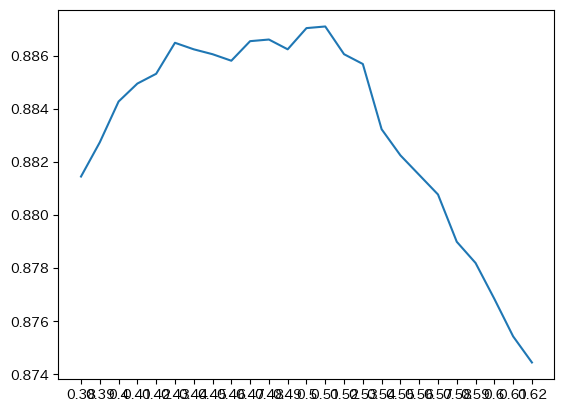

In [34]:
plt.plot(ansRateList_LGB[1])
plt.xticks(range(25),ansRateList_LGB[0])

XGBoostのモデル作成

In [35]:
model_XGB = XGBClassifier(early_stopping_rounds=10)

In [36]:
eval_set = [(X_test, y_test)]
model_XGB.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.54553
[1]	validation_0-logloss:0.46495
[2]	validation_0-logloss:0.41215
[3]	validation_0-logloss:0.38028
[4]	validation_0-logloss:0.35759
[5]	validation_0-logloss:0.34193
[6]	validation_0-logloss:0.33073
[7]	validation_0-logloss:0.32180
[8]	validation_0-logloss:0.31653
[9]	validation_0-logloss:0.31289
[10]	validation_0-logloss:0.30943
[11]	validation_0-logloss:0.30778
[12]	validation_0-logloss:0.30566
[13]	validation_0-logloss:0.30439
[14]	validation_0-logloss:0.30303
[15]	validation_0-logloss:0.30054
[16]	validation_0-logloss:0.30004
[17]	validation_0-logloss:0.30022
[18]	validation_0-logloss:0.29873
[19]	validation_0-logloss:0.29839
[20]	validation_0-logloss:0.29824
[21]	validation_0-logloss:0.29824
[22]	validation_0-logloss:0.29729
[23]	validation_0-logloss:0.29649
[24]	validation_0-logloss:0.29682
[25]	validation_0-logloss:0.29470
[26]	validation_0-logloss:0.29479
[27]	validation_0-logloss:0.29459
[28]	validation_0-logloss:0.29443
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
trainXpred_XGB = model_XGB.predict_proba(trainX)
trainXpred_XGB = trainXpred_XGB[:,1]
trainXl_XGB = len(trainXpred_XGB)
trainXpred_XGB = trainXpred_XGB.astype(object)
trainXpred_XGB

array([0.00339084817096591, 0.5295727252960205, 0.40462884306907654, ...,
       0.0178011953830719, 0.000357212673407048, 0.11315363645553589],
      dtype=object)

In [38]:
ansRateList_XGB = pd.DataFrame()
for j in range(25):
    c = trainXpred_XGB.copy()
    n = (38+j)/100
    for i in range(trainXl_XGB):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase_XGB = np.equal(c,y)
    ansRate_XGB = collections.Counter(ansRateBase_XGB)[True]/len(ansRateBase_XGB)
    ansRateData_XGB = pd.DataFrame([[n,ansRate_XGB]])
    ansRateList_XGB = pd.concat([ansRateList_XGB,ansRateData_XGB],ignore_index=True)
ansRateList_XGB

,0,1
0,0.38,0.886364
1,0.39,0.887162
2,0.40,0.888084
3,0.41,0.888452
4,0.42,0.888391
5,0.43,0.890233
6,0.44,0.890418
7,0.45,0.891708
8,0.46,0.892322
9,0.47,0.891892


([<matplotlib.axis.XTick at 0x2040fe25670>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

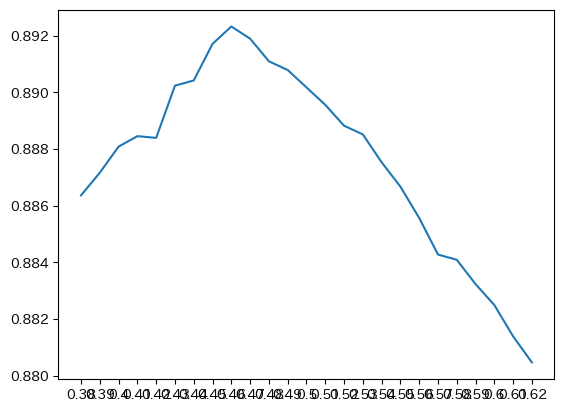

In [39]:
plt.plot(ansRateList_XGB[1])
plt.xticks(range(25),ansRateList_XGB[0])

3モデルの平均を取る

In [47]:
trainXpred = (trainXpred_DT + trainXpred_LGB + trainXpred_XGB)/3
trainXl = len(trainXpred)
trainXpred.shape

(16280,)

In [48]:
ansRateList = pd.DataFrame()
for j in range(25):
    c = trainXpred.copy()
    n = (38+j)/100
    for i in range(trainXl):
        if c[i] <= n:
            c[i] = 0
        else:
            c[i] = 1
    ansRateBase = np.equal(c,y)
    ansRate = collections.Counter(ansRateBase)[True]/len(ansRateBase)
    ansRateData = pd.DataFrame([[n,ansRate]])
    ansRateList = pd.concat([ansRateList,ansRateData],ignore_index=True)
ansRateList

,0,1
0,0.38,0.879914
1,0.39,0.881818
2,0.40,0.882740
3,0.41,0.883170
4,0.42,0.883477
5,0.43,0.883845
6,0.44,0.883661
7,0.45,0.883907
8,0.46,0.883600
9,0.47,0.883538


([<matplotlib.axis.XTick at 0x2040fd987f0>,
 [Text(0, 0, '0.38'),
  Text(1, 0, '0.39'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.41'),
  Text(4, 0, '0.42'),
  Text(5, 0, '0.43'),
  Text(6, 0, '0.44'),
  Text(7, 0, '0.45'),
  Text(8, 0, '0.46'),
  Text(9, 0, '0.47'),
  Text(10, 0, '0.48'),
  Text(11, 0, '0.49'),
  Text(12, 0, '0.5'),
  Text(13, 0, '0.51'),
  Text(14, 0, '0.52'),
  Text(15, 0, '0.53'),
  Text(16, 0, '0.54'),
  Text(17, 0, '0.55'),
  Text(18, 0, '0.56'),
  Text(19, 0, '0.57'),
  Text(20, 0, '0.58'),
  Text(21, 0, '0.59'),
  Text(22, 0, '0.6'),
  Text(23, 0, '0.61'),
  Text(24, 0, '0.62')])

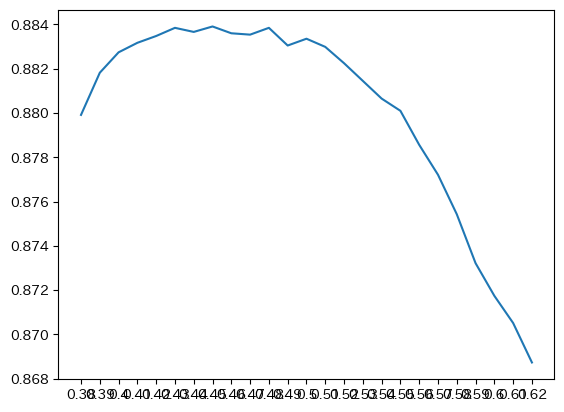

In [49]:
plt.plot(ansRateList[1])
plt.xticks(range(25),ansRateList[0])

予測に代入して結果を出力する

In [69]:
pred_DT = model_DT.predict_proba(testX)
pred_DT = pred_DT[:,1]
pred_LGB = model_LGB.predict(testX)
pred_XGB = model_XGB.predict_proba(testX)
pred_XGB = pred_XGB[:,1]
pred = (pred_DT + pred_LGB + pred_XGB)/3
pred.shape

(16281,)

In [73]:
pred_r = pred.astype(object)
l = len(pred_r)
for i in range(l):
    if pred_r[i] <= 0.51:
        pred_r[i] = "<=50K"
    else:
        pred_r[i] = ">50K"

In [74]:
sample[1] = pred_r

In [75]:
sample.to_csv("submit5_5.csv",index=None,header=None)